# Analyzing cloud-hosted AllWISE Source Catalog in Parquet format

## Learning Goals

- Learn how to load data from the AllWISE parquet catalog that is partitioned by HEALPix pixel index at order 5.

- Learn efficient methods for performing common types of searches. This includes:

  - query/load using pandas, applying basic filters
  - query/load using pyarrow, applying advanced filters that combine and/or compare columns
  - perform nearest neighbor searches using pyarrow and astropy

## Introduction

This notebook demonstrates access to the [HEALPix](https://ui.adsabs.harvard.edu/abs/2005ApJ...622..759G/abstract)-partitioned (order 5), [Apache Parquet](https://parquet.apache.org/) version of the [AllWISE Source Catalog](https://wise2.ipc.caltech.edu/docs/release/allwise/expsup/sec1_3.html#src_cat).
The catalog is available through the [AWS Open Data](https://aws.amazon.com/opendata) program, as part of the [NASA Open-Source Science Initiative](https://science.nasa.gov/open-science-overview).

Parquet is convenient for large astronomical catalogs in part because the storage format supports efficient database-style queries on the files themselves, without having to load the catalog into a database (or into memory) first.
The AllWISE catalog is fairly large at 340 GB.
The examples below demonstrate different methods that can be used to query the catalog, filtering the data and loading only the results.
Each method accesses the parquet files a bit differently and is useful for different types of queries.

## Imports

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install 'pandas>=1.5.2' 'pyarrow>=10.0.1' matplotlib hpgeom astropy

In [2]:
import sys

import hpgeom as hp
import pandas as pd
import pyarrow.compute as pc
import pyarrow.dataset as ds
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib import colors
from matplotlib import pyplot as plt
from pyarrow.fs import S3FileSystem

## Setup catalog paths and query filters

This AllWISE catalog is stored in an [AWS S3](https://aws.amazon.com/s3/) bucket.
To connect to an S3 bucket we just need to point the reader at S3 instead of the local filesystem, and pass in AWS credentials.
(Here, a "reader" is a python library that reads parquet files.)
We'll use [pyarrow.fs.S3FileSystem](https://arrow.apache.org/docs/python/generated/pyarrow.fs.S3FileSystem.html) for this because it is recognized by every reader in examples below, and we're already using pyarrow.
[s3fs](https://s3fs.readthedocs.io/en/latest/index.html) is another common option.
The call to `S3FileSystem` will look for AWS credentials in environment variables and/or the file ~/.aws/credentials.
Credentials can also be passed as keyword arguments.

In [3]:
bucket = "nasa-irsa-wise"
folder = "wise/allwise/catalogs/p3as_psd/healpix_k5"
parquet_root = f"{bucket}/{folder}/wise-allwise.parquet"

fs = S3FileSystem(region="us-west-2")  # the bucket is in region us-west-2

These limits will be used to query the catalog using specific filters created in examples below.
The Schema Access section (below) shows how to access column names and other schema information.

In [4]:
w1mpro_min = 10.0
ra_min, ra_max = 15, 25  # deg
dec_min, dec_max = 62, 72  # deg
polygon_corners = [(ra_min, dec_min), (ra_min, dec_max), (ra_max, dec_max), (ra_max, dec_min)]
radius = 5 * u.arcmin.to(u.deg)

The catalog is partitioned by HEALPix pixel index at order 5.
Queries can be most efficient when a filter on the partition column is included, since the reader can skip those partitions entirely.
Thus, for queries that include ra/dec constraints, we can usually speed up load times significantly by including a constraint on the HEALPix order 5 pixel index.
The required pixel indexes can be calculated using [hpgeom](https://hpgeom.readthedocs.io/en/latest/index.html), as demonstrated here.

In [5]:
order = 5  # the catalog is partitioned by HEALPix pixel index at order 5
nside = hp.order_to_nside(order)  # number of order 5 pixels along one side of a base pixel

In [6]:
# polygon search: get the set of pixel indexes that overlap the ra/dec polygon
polygon_pixels = hp.query_polygon(
    nside=nside,
    a=[corner[0] for corner in polygon_corners],  # ra values
    b=[corner[1] for corner in polygon_corners],  # dec values
    nest=True,  # catalog uses nested ordering scheme for pixel index
    inclusive=True,  # return all pixels that overlap with the polygon, and maybe a few more
)

print(f"polygon_pixels contains {len(polygon_pixels)} of a possible {hp.nside_to_npixel(nside)} pixels")

polygon_pixels contains 25 of a possible 12288 pixels


In [7]:
# cone search: get the set of pixel indexes that overlap a 5' circle around the ra/dec min
cone_pixels = hp.query_circle(
    nside=nside,
    a=ra_min,
    b=dec_min,
    radius=radius,
    nest=True,  # catalog uses nested ordering scheme for pixel index
    inclusive=True,  # return all pixels that overlap with the disk, and maybe a few more
)

# this can reduce the number of partitions the reader needs to look at from 12288 down to 2
print(f"cone_pixels contains {len(cone_pixels)} of a possible {hp.nside_to_npixel(nside)} pixels")

cone_pixels contains 2 of a possible 12288 pixels


## Example 1:  Pandas with basic filters (magnitude limit and ra/dec polygon)

Load using [pandas.read_parquet](https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html).
Filter for magnitudes above our w1mpro limit and a sky-area limited to the ra/dec polygon.

Pandas actually uses either pyarrow or fastparquet to interact with parquet files.
We'll choose pyarrow (the default).
For filter options, see the `filters` arg description in [ParquetDataset](https://arrow.apache.org/docs/python/generated/pyarrow.parquet.ParquetDataset.html#pyarrow.parquet.ParquetDataset).

In [8]:
%%time
# expect this to take 40-90 seconds
pandas_df = pd.read_parquet(
    parquet_root,
    filesystem=fs,
    # columns to be returned. similar to a SQL SELECT clause.
    columns=["designation", "ra", "dec", "w1mpro", "healpix_k5"],
    # row filters. similar to a SQL WHERE clause.
    # tuple conditions are joined by AND (for OR, use a list of lists)
    # supported operators: ==, !=, <, >, <=, >=, in, not in
    filters=[
        ("w1mpro", ">", w1mpro_min),
        ("ra", ">", ra_min),
        ("ra", "<", ra_max),
        ("dec", ">", dec_min),
        ("dec", "<", dec_max),
        # include filter on partition column for most efficient loading
        ("healpix_k5", "in", polygon_pixels),
    ],
)

pandas_df.describe()

CPU times: user 6.13 s, sys: 1.6 s, total: 7.73 s
Wall time: 27.4 s


,ra,dec,w1mpro
count,870641.000000,870641.000000,870641.000000
mean,20.014620,66.582893,14.788122
std,2.900022,2.835385,1.441931
min,15.000000,62.000001,10.001000
25%,17.489370,64.121702,14.003000
50%,20.038686,66.416329,14.992000
75%,22.525137,68.928682,15.792000
max,25.000000,71.999960,19.079000


## Example 2:  Pyarrow with advanced filters (color-color cuts for AGN)

Load using [pyarrow.dataset.parquet_dataset](https://arrow.apache.org/docs/python/generated/pyarrow.dataset.parquet_dataset.html) and convert to pandas.
Useful for:

1. advanced filters that combine, compare, and/or create new columns. (this example)
2. speed. This method is more efficient at "discovering" the dataset than pandas. It also provides a persistent dataset object that can be reused for future queries, where pandas must re-discover the dataset every time. (this example and Example 3)

This example filters the catalog for AGN by making cuts in color-color space using the selection limits from [Mateos et al. (2012)](https://arxiv.org/pdf/1208.2530.pdf).
This is a more complicated filter than in Example 1 (it requires both constructing new columns and comparing values between columns) but this load is generally faster, demonstrating the efficiency of this method.

For basic info about the `columns` and `filter` arguments, see [Scanner](https://arrow.apache.org/docs/python/generated/pyarrow.dataset.Scanner.html#pyarrow.dataset.Scanner.from_dataset).
The construction of columns/filters is more involved than before because they must be passed as [Expressions](https://arrow.apache.org/docs/python/generated/pyarrow.dataset.Expression.html#pyarrow.dataset.Expression), and all operations must be done using pyarrow.compute [functions](https://arrow.apache.org/docs/python/api/compute.html) and `field`s.
This is demonstrated below.
Note that the catalog uses a file naming scheme called "hive", which the reader uses to identify partitions.
In other examples this is recognized automatically, but here we must pass it explicitly.

In [9]:
# define new columns for colors W1-W2 and W3-W4
w1w2 = pc.subtract(pc.field("w1mpro"), pc.field("w2mpro"))
w3w4 = pc.subtract(pc.field("w3mpro"), pc.field("w4mpro"))

# define the AGN locus, as in Mateos et al., 2012
locus = pc.multiply(pc.scalar(0.5), w3w4)

In [10]:
%%time
# expect this to take 20-60 seconds.
# notice this is generally faster than example 1 using pandas even though
# this filter is much more complicated, highlighting the efficiency of this method.

# load catalog metadata as a pyarrow dataset
pyarrow_ds = ds.parquet_dataset(f"{parquet_root}/_metadata", filesystem=fs, partitioning="hive")

# query for AGN using selection limits from Mateos et al., 2012
pyarrow_df = pyarrow_ds.to_table(
    # column filter. similar to a SQL SELECT clause.
    columns={
        "w1w2": w1w2,
        "w3w4": w3w4,
        "cntr": pc.field("cntr"),
        "ra": pc.field("ra"),
        "dec": pc.field("dec"),
        "healpix_k5": pc.field("healpix_k5"),
    },
    # row filter. similar to a SQL WHERE clause.
    filter=(
        # color-color cuts
        (w1w2 < pc.add(locus, pc.scalar(0.979)))
        & (w1w2 > pc.subtract(locus, pc.scalar(0.405)))
        & (w3w4 > pc.scalar(1.76))
        # to do an all-sky search, comment out the rest of the filter. expect it to take 30-60 min
        # same ra/dec polygon as before
        & (pc.field("ra") > ra_min)
        & (pc.field("ra") < ra_max)
        & (pc.field("dec") > dec_min)
        & (pc.field("dec") < dec_max)
        # same partition-column filter as before
        & (pc.field("healpix_k5").isin(polygon_pixels))
    ),
).to_pandas()

CPU times: user 4.15 s, sys: 2.41 s, total: 6.57 s
Wall time: 13.7 s


In [11]:
len(pyarrow_df.index)

3750

<Axes: xlabel='w3w4', ylabel='w1w2'>

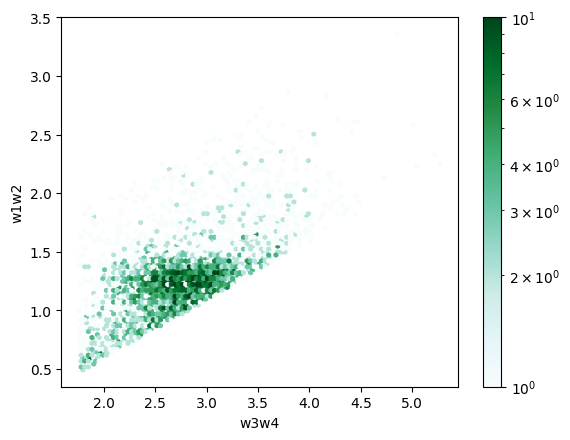

In [12]:
colorbar_norm = colors.LogNorm(vmin=1, vmax=10)  # for an all-sky search, use vmax=100_000
pyarrow_df.plot.hexbin("w3w4", "w1w2", norm=colorbar_norm)

## Example 3:  Nearest-neighbor search (using pyarrow and astropy)

Nearest-neighbor searches and cone searches generally use the on-sky separation distance to determine the matches.
It would be cumbersome to construct the new column and filter on it using the methods shown above because the separation distance is a fairly complicated function of ra and dec.
However, we can get pretty fast results by filtering down to the HEALPix pixels that cover the region, loading all the data in those partitions, and then using astropy to compute the separations and find the matches.

Here, we'll search for the 3 nearest neighbors to each of the 4 corners of our ra/dec polygon.
We'll load the data with pyarrow because because it makes this query significantly faster than with pandas (see explanation in Example 2).
(Note that astropy can also read parquet, but it can only read a single file at a time and so is less convenient.)
We'll use [astropy.coordinates.SkyCoord.match_to_catalog_sky](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.match_to_catalog_sky) to do the actual nearest neighbor search.

In [13]:
# construct dictionary of pixels covering a cone around each polygon corner
# we did this once before but now we want all 4 corners
corner_cone_pixels = {
    (ra, dec): hp.query_circle(nside=nside, a=ra, b=dec, radius=radius, nest=True, inclusive=True)
    for (ra, dec) in polygon_corners
}
corner_cone_pixels

{(15, 62): array([757, 928]),
 (15, 72): array([947, 950, 953]),
 (25, 72): array([948, 949]),
 (25, 62): array([908])}

Find the 3 nearest neighbors of each corner:

In [14]:
%%time
# expect this to take 30-60 seconds
idcol = "cntr"
neighbor_ids = []  # store the allwise source id (cntr) of each neighbor
corner_neighbors = {}  # record neighbor info for each corner (for reference. not actually used)

# use same pyarrow dataset as before, but get it again to include the load time in this cell
pyarrow_ds = ds.parquet_dataset(f"{parquet_root}/_metadata", filesystem=fs, partitioning="hive")

for (ra, dec), cone_pixels in corner_cone_pixels.items():

    # load data from all pixels/partitions/files covering this corner
    src_tbl = pyarrow_ds.to_table(
        columns=[idcol, "ra", "dec"], filter=(pc.field("healpix_k5").isin(cone_pixels))
    )

    # get list of 3 nearest neighbors to this corner
    corner = SkyCoord(ra=ra * u.degree, dec=dec * u.degree)
    allwise_sources = SkyCoord(ra=src_tbl["ra"] * u.degree, dec=src_tbl["dec"] * u.degree)
    neighbors = [corner.match_to_catalog_sky(allwise_sources, nthneighbor=i) for i in range(1, 4)]

    # get the allwise source ids. record/report some info
    corner_neighbors[(ra, dec)] = []
    for n, (idx, sep, _) in enumerate(neighbors):
        srcid = src_tbl[idcol][idx.item()].as_py()
        neighbor_ids.append(srcid)
        corner_neighbors[(ra, dec)].append((srcid, sep))
        print(f"neighbor {n+1}, corner ({ra}, {dec}): {srcid} at on-sky dist {sep.to('arcsec')}")

neighbor_ids

neighbor 1, corner (15, 62): 157162001351035963 at on-sky dist [7.90224006] arcsec
neighbor 2, corner (15, 62): 157162001351036469 at on-sky dist [8.50715008] arcsec
neighbor 3, corner (15, 62): 157162001351035211 at on-sky dist [10.86567525] arcsec
neighbor 1, corner (15, 72): 145172601351006308 at on-sky dist [10.93439298] arcsec
neighbor 2, corner (15, 72): 145172601351005598 at on-sky dist [25.54305849] arcsec
neighbor 3, corner (15, 72): 145172601351004924 at on-sky dist [28.06138449] arcsec
neighbor 1, corner (25, 72): 243172601351002865 at on-sky dist [12.86477229] arcsec
neighbor 2, corner (25, 72): 243172601351004919 at on-sky dist [22.84314776] arcsec
neighbor 3, corner (25, 72): 243172601351003808 at on-sky dist [22.86047987] arcsec
neighbor 1, corner (25, 62): 252162001351031532 at on-sky dist [7.458129] arcsec
neighbor 2, corner (25, 62): 252162001351031550 at on-sky dist [14.2719862] arcsec
neighbor 3, corner (25, 62): 252162001351031549 at on-sky dist [18.96407889] arcse

neighbor 1, corner (15, 72): 145172601351006308 at on-sky dist [10.93439298] arcsec
neighbor 2, corner (15, 72): 145172601351005598 at on-sky dist [25.54305849] arcsec
neighbor 3, corner (15, 72): 145172601351004924 at on-sky dist [28.06138449] arcsec


neighbor 1, corner (25, 72): 243172601351002865 at on-sky dist [12.86477229] arcsec
neighbor 2, corner (25, 72): 243172601351004919 at on-sky dist [22.84314776] arcsec
neighbor 3, corner (25, 72): 243172601351003808 at on-sky dist [22.86047987] arcsec


neighbor 1, corner (25, 62): 252162001351031532 at on-sky dist [7.458129] arcsec
neighbor 2, corner (25, 62): 252162001351031550 at on-sky dist [14.2719862] arcsec
neighbor 3, corner (25, 62): 252162001351031549 at on-sky dist [18.96407889] arcsec
CPU times: user 7.61 s, sys: 9.8 s, total: 17.4 s
Wall time: 55.3 s


[157162001351035963,
 157162001351036469,
 157162001351035211,
 145172601351006308,
 145172601351005598,
 145172601351004924,
 243172601351002865,
 243172601351004919,
 243172601351003808,
 252162001351031532,
 252162001351031550,
 252162001351031549]

Load all the data (all columns) for all nearest neighbors:

In [15]:
%%time
# expect this to take 15-25 seconds
cone_pixels = [pixel for cone_pixels in corner_cone_pixels.values() for pixel in cone_pixels]
neighbors_df = pyarrow_ds.to_table(
    filter=((pc.field(idcol).isin(neighbor_ids)) & (pc.field("healpix_k5").isin(cone_pixels)))
).to_pandas()

neighbors_df

CPU times: user 2.27 s, sys: 2.29 s, total: 4.57 s
Wall time: 4.63 s


,designation,ra,dec,sigra,sigdec,sigradec,glon,glat,elon,elat,...,h_msig_2mass,k_m_2mass,k_msig_2mass,x,y,z,spt_ind,htm20,healpix_k0,healpix_k5
0,J013958.40+620015.2,24.993333,62.004237,0.0398,0.0489,-0.0058,128.594461,-0.332646,51.412734,46.989544,...,0.040,11.843,0.030,0.425450,0.198330,0.882982,231130002,16887982685832,0,908
1,J013958.51+620009.7,24.993832,62.002708,0.1038,0.1627,-0.0660,128.594977,-0.334105,51.411840,46.988121,...,0.054,13.759,0.054,0.425469,0.198344,0.882970,231130002,16887982683755,0,908
2,J014000.56+615953.6,25.002354,61.998248,0.0398,0.0379,0.0094,128.599742,-0.337737,51.413364,46.982221,...,0.032,11.662,0.019,0.425502,0.198436,0.882933,231130002,16887983158948,0,908
3,J005959.07+615955.5,14.996146,61.998757,0.0868,0.0854,-0.0219,123.934996,-0.856265,45.573400,49.619268,...,0.162,15.280,0.162,0.453501,0.121483,0.882937,231122233,16882422834846,0,928
4,J005959.19+620006.3,14.996627,62.001754,0.1677,0.1633,-0.0432,123.935122,-0.853262,45.576424,49.621547,...,NaN,NaN,NaN,0.453456,0.121474,0.882962,231122233,16882422833160,0,928
5,J010001.07+620007.7,15.004480,62.002165,0.0534,0.0510,0.0053,123.938794,-0.852729,45.581382,49.619691,...,0.055,13.940,0.059,0.453433,0.121535,0.882965,231122233,16882422783986,0,928
6,J005956.32+720019.0,14.984687,72.005287,0.0997,0.0960,-0.0153,123.596773,9.144601,56.543000,57.227891,...,0.125,15.182,0.143,0.298424,0.079877,0.951085,231010101,16785925865144,0,947
7,J010001.48+715951.5,15.006188,71.997640,0.2109,0.2034,-0.0539,123.603758,9.137181,56.541620,57.217789,...,NaN,15.436,0.165,0.298517,0.080022,0.951044,231010101,16785926933871,0,947
8,J010002.55+720025.4,15.010649,72.007066,0.0514,0.0498,0.0083,123.604831,9.146649,56.555769,57.223452,...,0.038,13.571,0.043,0.298359,0.080005,0.951095,231010101,16785925808192,0,947
9,J013956.82+720017.4,24.986791,72.004858,0.5317,0.5261,-0.1661,126.704895,9.489459,60.653660,55.154163,...,NaN,NaN,NaN,0.280022,0.130498,0.951083,231322133,17018750630425,0,949


## Schema Access

The schema can be viewed [online](http://wise2.ipac.caltech.edu/docs/release/allwise/expsup/sec2_1a.html) and also accessed from the parquet catalog itself.
The example below loads it using the `_common_metadata` file and [pyarrow.dataset.parquet_dataset](https://arrow.apache.org/docs/python/generated/pyarrow.dataset.parquet_dataset.html).
Note that the schema can also be accessed from the metadata in the footer of each Parquet file and from the `_metadata` file, but the method used here is generally faster and easier.
In addition, this `_common_metadata` file has extra information (units and descriptions) stored in the custom metadata of each column.

In [16]:
schema = ds.parquet_dataset(f"{parquet_root}/_common_metadata", filesystem=fs).schema

In [17]:
# access individual columns by name or index
fld = schema.field(1)  # equivalently: fld = schema.field("ra")

# basic column information
print(fld.name)
print(fld.type)
print(fld.nullable)

# units and descriptions are in the `metadata` attribute, always as bytestrings
print(fld.metadata)
print(fld.metadata[b"units"].decode())  # use decode to get a regular string
print(fld.metadata[b"description"].decode())

ra
double
False
{b'units': b'deg', b'description': b'J2000 right ascension with respect to the 2MASS PSC reference frame from the non-moving source extraction.'}
deg
J2000 right ascension with respect to the 2MASS PSC reference frame from the non-moving source extraction.


In [18]:
# full list of column names
schema.names

['designation',
 'ra',
 'dec',
 'sigra',
 'sigdec',
 'sigradec',
 'glon',
 'glat',
 'elon',
 'elat',
 'wx',
 'wy',
 'cntr',
 'source_id',
 'coadd_id',
 'src',
 'w1mpro',
 'w1sigmpro',
 'w1snr',
 'w1rchi2',
 'w2mpro',
 'w2sigmpro',
 'w2snr',
 'w2rchi2',
 'w3mpro',
 'w3sigmpro',
 'w3snr',
 'w3rchi2',
 'w4mpro',
 'w4sigmpro',
 'w4snr',
 'w4rchi2',
 'rchi2',
 'nb',
 'na',
 'w1sat',
 'w2sat',
 'w3sat',
 'w4sat',
 'satnum',
 'ra_pm',
 'dec_pm',
 'sigra_pm',
 'sigdec_pm',
 'sigradec_pm',
 'pmra',
 'sigpmra',
 'pmdec',
 'sigpmdec',
 'w1rchi2_pm',
 'w2rchi2_pm',
 'w3rchi2_pm',
 'w4rchi2_pm',
 'rchi2_pm',
 'pmcode',
 'cc_flags',
 'rel',
 'ext_flg',
 'var_flg',
 'ph_qual',
 'det_bit',
 'moon_lev',
 'w1nm',
 'w1m',
 'w2nm',
 'w2m',
 'w3nm',
 'w3m',
 'w4nm',
 'w4m',
 'w1cov',
 'w2cov',
 'w3cov',
 'w4cov',
 'w1cc_map',
 'w1cc_map_str',
 'w2cc_map',
 'w2cc_map_str',
 'w3cc_map',
 'w3cc_map_str',
 'w4cc_map',
 'w4cc_map_str',
 'best_use_cntr',
 'ngrp',
 'w1flux',
 'w1sigflux',
 'w1sky',
 'w1sigsk',
 '

***

## About this notebook

**Author:** Troy Raen (IRSA Developer) in conjunction with David Shupe, Jessica Krick and the IPAC Science Platform team

**Updated:** 2023-07-27

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.